# PD6

Used images credits: AT&T Laboratories Cambridge ([as stated here](https://scikit-learn.org/stable/datasets/real_world.html#olivetti-faces-dataset))

In [1]:
from sklearn.datasets import fetch_olivetti_faces
import pandas as pd
oliv_all = fetch_olivetti_faces(shuffle=True)
oliv_train = oliv_all.data[:300]
oliv_test = oliv_all.data[300:]

So we've got 400 rows (images), each has 4096 pixels (64x64). I've split it to 300 train images and 100 test.

## 0. Sample faces

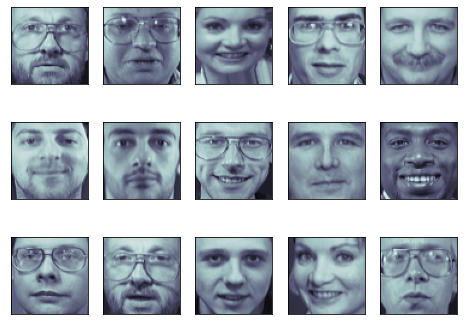

In [2]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(oliv_train[i].reshape(64,64), cmap=plt.cm.bone, vmin=0, vmax=1)

## PCA

`whiten=True` was set, explanation [here](http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening).

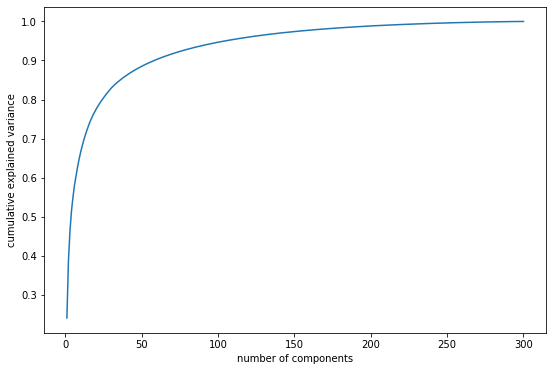

In [3]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(whiten=True).fit(oliv_train)
plt.figure(figsize=(9,6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [4]:
pca = PCA(whiten=True, n_components=0.97).fit(oliv_train)
oliv_transformed = pca.transform(oliv_test)
oliv_transformed.shape[1]

140

I chose 140 components to loose less than 3% of variance. 

Data compression ratio is a ratio between a number of numeric values necessary to save an image after and before the pca transformation. At the beginning each picture had 4096 pixels in gray scale, now it has only 140 "pixels". 

In [5]:
print("Data compression ratio is", round(1-140/4096,2)*100, "%")

Data compression ratio is 97.0 %


## 2. Inverse transform

In [6]:
oliv_inversed = pca.inverse_transform(oliv_transformed)

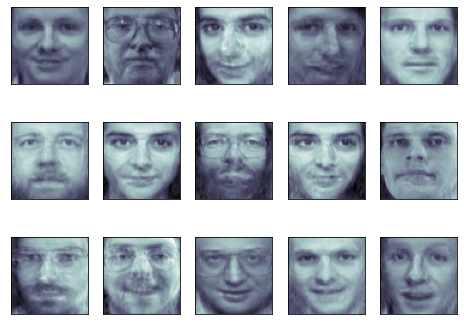

In [7]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(oliv_inversed[i].reshape(64,64), cmap=plt.cm.bone, vmin=0, vmax=1)

To compare 2 images before and after:

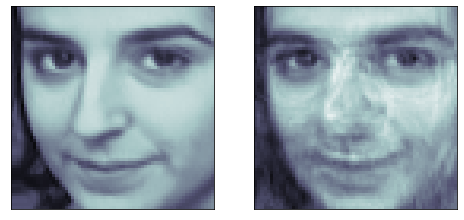

In [8]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
ax1.imshow(oliv_test[2].reshape(64,64), cmap=plt.cm.bone, vmin=0, vmax=1)
ax2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax2.imshow(oliv_inversed[2].reshape(64,64), cmap=plt.cm.bone, vmin=0, vmax=1)
plt.show()

The original picture is on the left and after pca and inverse pca is on the right. On the train set more than 97% of all variance has been preserved in the pca compression, but here... well, the image on the right it visibly different from the original.

#### RMSE of reconstruction on train data

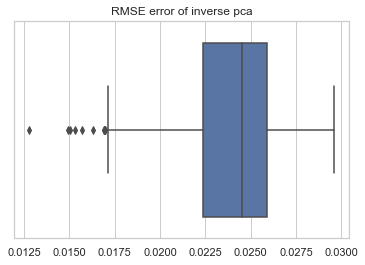

In [9]:
from sklearn.metrics import mean_squared_error
rmse_scores = [0 for i in range(300)]
for i in range(300):
    rmse_scores[i] = mean_squared_error(oliv_train[i], pca.inverse_transform(pca.transform(oliv_train))[i], squared=False)

import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=rmse_scores).set(title="RMSE error of inverse pca")

In [10]:
from statistics import median
print("Median reconstruction error is:",round(median(rmse_scores),3))

Median reconstruction error is: 0.025


### RMSE of reconstruction on test data

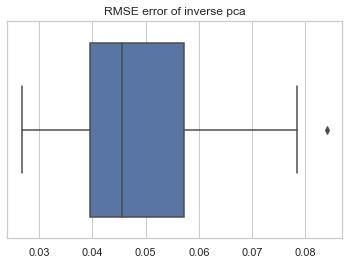

In [11]:
from sklearn.metrics import mean_squared_error
rmse_scores = [0 for i in range(100)]
for i in range(100):
    rmse_scores[i] = mean_squared_error(oliv_test[i], oliv_inversed[i], squared=False)

import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=rmse_scores).set(title="RMSE error of inverse pca")

In [12]:
from statistics import median
print("Median reconstruction error is:",round(median(rmse_scores),3))

Median reconstruction error is: 0.046


As you can see, the median error on the train set is around 0.025 (very small) and on the new images (test set) this median error is nearly twice as high (around 0.046).

## Rotations and other transformations

In [13]:
rotated = np.ndarray((25, 4096), float)
for i in range(0,25):
    rotated[i] = oliv_test[i].reshape(64, 64).transpose().reshape(4096)

darkened = np.ndarray((25, 4096), float)
for i in range(25, 50):
    for j in range(oliv_test[i].shape[0]):
        darkened[i-25][j] = max(0,oliv_test[i][j]*0.7)

flipped = np.ndarray((25, 4096), float)
for i in range(50,75):
    flipped[i-50] = oliv_test[i].reshape(64, 64)[::-1,...].reshape(4096,)

unmodified = np.ndarray((25, 4096), float)
for i in range(75,100):
    unmodified[i-75] = oliv_test[i]

def plotsomefaces(data, count=15):  
    fig = plt.figure(figsize=(8, 6))
    for i in range(count):
        ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(data[i].reshape(64,64), cmap=plt.cm.bone, vmin=0, vmax=1)

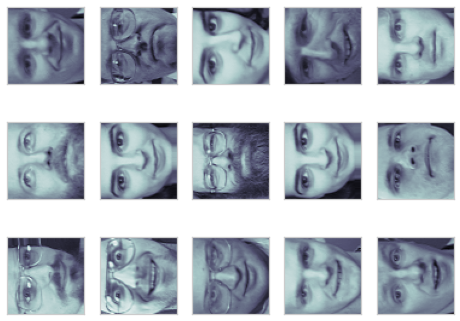

In [14]:
plotsomefaces(rotated)

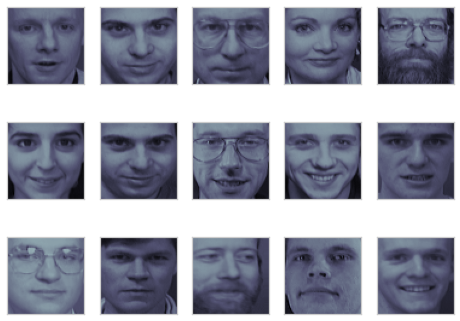

In [15]:
plotsomefaces(darkened)

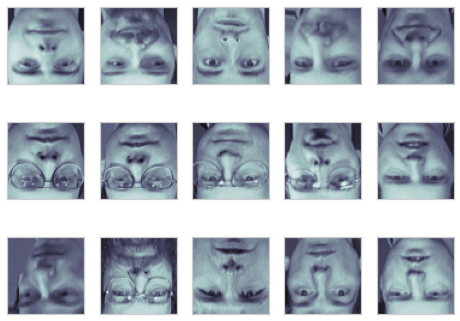

In [16]:
plotsomefaces(flipped)

## PCA and inversePCA and RMSE once more

In [17]:
from statistics import median
from sklearn.metrics import mean_squared_error
import seaborn as sns

def getRMSE(original, modded, title="RMSE error of inverse pca"):
    rmse_scores = [0 for i in range(original.shape[0])]
    for i in range(original.shape[0]):
        rmse_scores[i] = mean_squared_error(original[i], pca.inverse_transform(modded)[i], squared=False)

    sns.set_theme(style="whitegrid")
    ax = sns.boxplot(x=rmse_scores).set(title=title)
    print("Median reconstruction error is:",round(median(rmse_scores),3))
    plt.show()
    return rmse_scores

Median reconstruction error is: 0.174


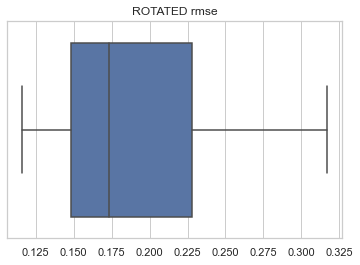

In [18]:
rmse_rotated = getRMSE(oliv_test[:25] , pca.transform(rotated), title="ROTATED rmse")

Median reconstruction error is: 0.179


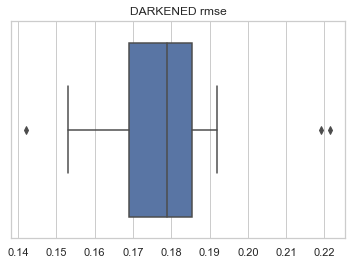

In [19]:
rmse_darkened = getRMSE(oliv_test[25:50] , pca.transform(darkened), title="DARKENED rmse")

Median reconstruction error is: 0.172


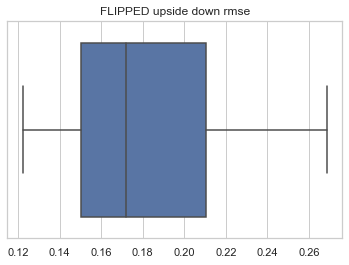

In [20]:
rmse_flipped = getRMSE(oliv_test[50:75] , pca.transform(flipped), title="FLIPPED upside down rmse")

Median reconstruction error is: 0.047


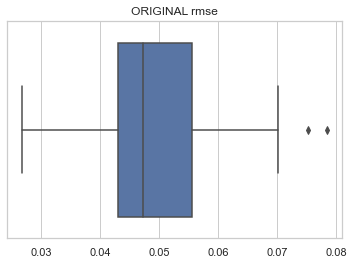

In [21]:
rmse_original = getRMSE(oliv_test[75:] , pca.transform(oliv_test[75:]), title="ORIGINAL rmse")

### Errors of all these transformations on a single plot

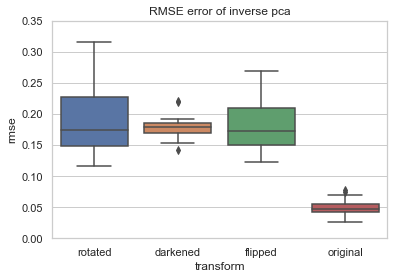

In [22]:
df_rmse = pd.DataFrame({"rmse":rmse_rotated + rmse_darkened + rmse_flipped + rmse_original, 
                "transform":['rotated' for i in range(len(rmse_rotated))] + 
                           ['darkened' for i in range(len(rmse_darkened))] +
                           ['flipped' for i in range(len(rmse_flipped))] +
                           ['original' for i in range(len(rmse_original))]})
ax = sns.boxplot(x="transform", y="rmse", data=df_rmse)
ax.set(title="RMSE error of inverse pca")
ax.set_ylim(0,0.35)
plt.show()

## Summary

PCA reconstruction error is much higher when the image has been roteted/flipped/darkened. Therefore PCA may be used to detect anomalies such as a face not aligned properly with the camera, rotated or in incorrect light conditions. Unmodified test data got errors visibly lower than modified faces despite the fact that they were not used in training pca.